In [1]:
#***********************************************************************************************#
# Implementación en Qiskit de la mitigación del error en la medida en los circuitos cuánticos
#***********************************************************************************************#

#***********************************************************************************************#

# Para esta implementación se ha tenido en cuenta el siguiente tutorial:
# https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/Coding_With_Qiskit/ep8_Noise_and_Error_Mitigation.ipynb

#***********************************************************************************************#
# Curso de Computación Cuántica
# Prof. Gustavo Patino
# Departamento de Ingeniería Electrónica y Telecomunicaciones
# Facultad de Ingeniería
# Universidad de Antioquia
# Medellin, 2022.
#***********************************************************************************************#

In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
from qiskit import *

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/tmp/ipykernel_1387/311139896.py:11: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)


In [3]:
# Loading your IBM Quantum account(s)
Account=IBMQ.load_account()

In [4]:
# Descomente la siguiente linea si desea ver las imágenes más grandes.
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [5]:
#***********************************************************************************************#
# Primer circuito de ejemplo 
# Análisis y simulación, y posterior ejecución en un procesador real
# Luego se le aplicará Mitigación de Error en el Medida
#***********************************************************************************************#

In [6]:
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure([0,1,2], [0,1,2])

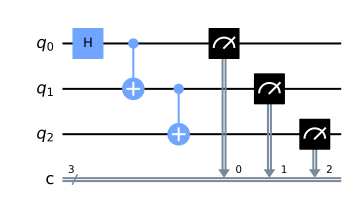

In [7]:
circuit.draw(output='mpl')

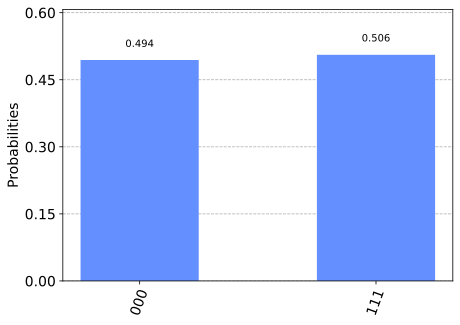

In [8]:
simulator = Aer.get_backend('qasm_simulator')

sim_result = execute(circuit, backend=simulator, shots=1024).result()
plot_histogram(sim_result.get_counts(circuit))

In [9]:
provider = IBMQ.get_provider(hub='ibm-q-education', group='uni-antioquia-1', project='qc2021')

Remote_QProcessor = provider.get_backend('ibm_perth')
#Remote_QSimulator = provider.get_backend('ibmq_qasm_simulator')

In [10]:
job = execute(circuit, backend=Remote_QProcessor, shots=1024)
#job = execute(circuit, backend=Remote_QSimulator, shots=1024)

#job_monitor(job)

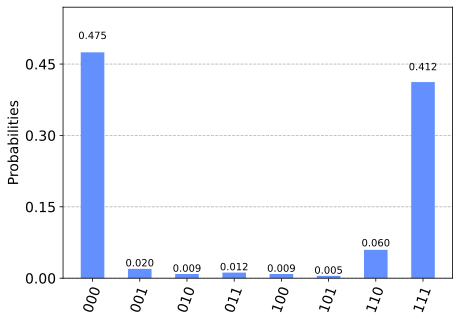

In [11]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [12]:
#***********************************************************************************************#
# Obtención de los circuitos de calibración para mitigar el error en el medida.
#***********************************************************************************************#

In [13]:
calibration_circuits, quantum_states = complete_meas_cal(qr=circuit.qregs[0], 
                                               circlabel='measurement_calibration')

In [14]:
quantum_states

['000', '001', '010', '011', '100', '101', '110', '111']

In [15]:
len(calibration_circuits)

8

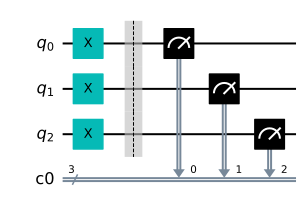

In [16]:
# Drawing the calibration circuit corresponding to the state |111> (= state |7>)

calibration_circuits[7].draw(output='mpl')

In [17]:
# Execution of every calibration circuit

calibration_job = execute(calibration_circuits, backend=Remote_QProcessor, shots=8192, optimization_level=0)
#calibration_job = execute(calibration_circuits, backend=Remote_QSimulator, shots=8192, optimization_level=0)

#job_monitor(calibration_job)
calibration_results = calibration_job.result()

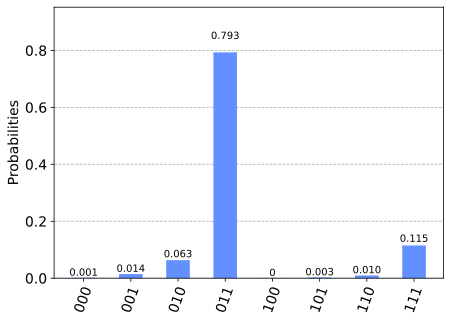

In [18]:
# Plotting the histogram of the calibration circuit associated to the state |011> (= state |3>)

plot_histogram(calibration_results.get_counts(calibration_circuits[3]))

In [19]:
My_fitter = CompleteMeasFitter(calibration_results, quantum_states)

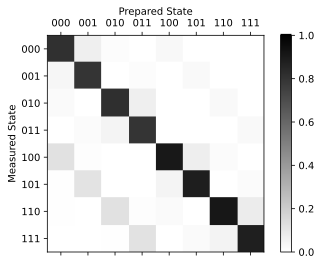

In [20]:
My_fitter.plot_calibration()

In [21]:
Measurement_Filter = My_fitter.filter

In [22]:
#***********************************************************************************************#
# Mitigación de los errores de la medida en la ejecución del primer ejemplo
#***********************************************************************************************#

In [23]:
mitigated_result = Measurement_Filter.apply(device_result)

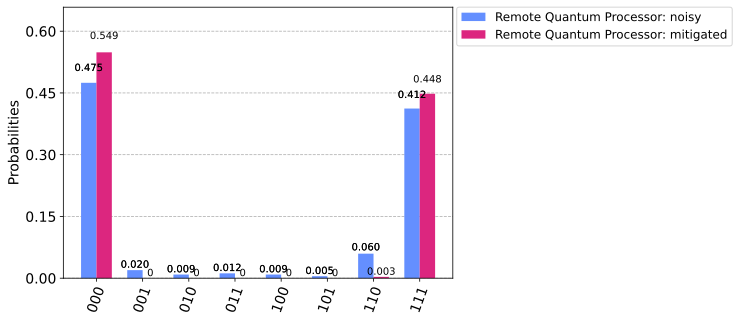

In [25]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)

plot_histogram([device_counts, mitigated_counts], 
               legend=['Remote Quantum Processor: noisy', 'Remote Quantum Processor: mitigated'])

In [26]:
#***********************************************************************************************#
# Segundo circuito de ejemplo:
#***********************************************************************************************#

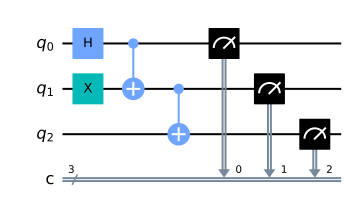

In [27]:
circuit2 = QuantumCircuit(3,3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0,1)
circuit2.cx(1,2)
circuit2.measure([0,1,2], [0,1,2])

circuit2.draw(output='mpl')

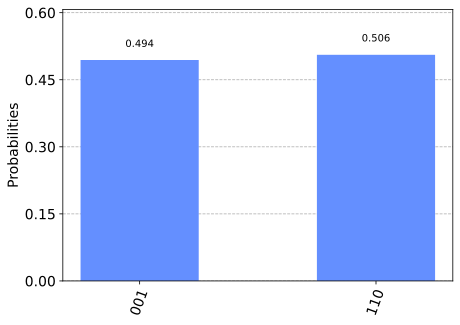

In [28]:
# Simulating the circuit and plotting the corresponding histogram:

Simulation_counts_2 = execute(circuit2, backend=simulator, shots=1024).result().get_counts(circuit2)
plot_histogram(Simulation_counts_2)

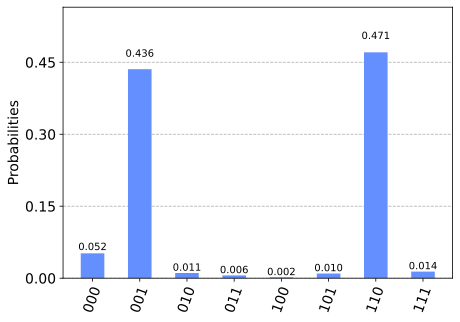

In [29]:
# Executing the circuit and plotting the corresponding histogram:

device_counts_2 = execute(circuit2, backend=Remote_QProcessor, shots=1024).result().get_counts(circuit2)
#device_counts_2 = execute(circuit2, backend=Remote_QSimulator, shots=1024).result().get_counts(circuit2)

plot_histogram(device_counts_2)

In [30]:
mitigated_counts_2 = Measurement_Filter.apply(device_counts_2)

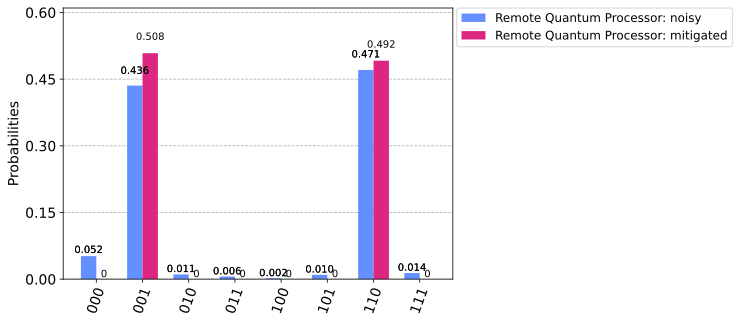

In [31]:
plot_histogram([device_counts_2, mitigated_counts_2], 
               legend=['Remote Quantum Processor: noisy', 'Remote Quantum Processor: mitigated'])

In [32]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright